# Project: Modeling Earthquake Damage



## 1. Dataset Description


The data was collected during the post-earthquake field surveys conducted by the Nepal National Planning Commission and partners following the 2015 Gorkha earthquake. Trained enumerators visited the affected areas and collected information on the level of damage, structural characteristics (foundation, roof, building materials), household information, age, location information, and building use for over 250,000 buildings. The damage level for buildings is categorized from low damage to almost complete destruction.


The data was gotten from [drivendata](https://www.drivendata.org/competitions/57/nepal-earthquake/page/136/) as part of the Earthquake Modeling Damage Competition. The totality of the data is available through the [Nepal Earthquake Open Data Portal](http://eq2015.npc.gov.np/#/).

Originally, the data was provided in three seperate files:
 - train_values
 - train_labels
 - test_values 
 
 The train_value files contains the feature describing each building, while train_labels provide the corresponding target variable, damage_grade, which indicates the level of structural damage.
For this project, the train_values and the train_labels datasets were merged using the unique building identifier to form a single training dataset. The test_values file were not used since the target labels for it were not provided.

**Why the data was collected**

Although the primary goal of the survey was to identify beneficiaries eligible for government assistance for housing reconstruction, it also collected other useful socio-economic information which serves different uses including training ML tasks. After disasters, government and humanitarian organization usually need rapid and reliable estimates of building damage to prioritize emergency response, assess vulnerability to guide future preparedness and plan recovery operations.

**Application Domain**

The data was collected as part of a national post-disaster assesment effort so it's aplication domain falls under disaster risk management, specifically post-disaster damage assessment. By understanding which features contribute most to level of damages, the project can provide insight useful for improving building construction in earthquake-prone areas.

**Learning task to study**

The target variable 'damage_grade' represents a discrete numerical value that indicates the level of damage to building. The damage_grade contains distinct values from 1-3. This problem is formulated as a multi-class classification task with the aim of predicting one of several damage grades for each building. 


In [1]:
# !pip install --upgrade scikit-learn==1.7.2

In [2]:
import os
import multiprocessing

print("Logical cores available:", os.cpu_count())
print("Multiprocessing cores:", multiprocessing.cpu_count())
# Set number of threads you want to use
os.environ["OMP_NUM_THREADS"] = "6"      # OpenMP threads
os.environ["MKL_NUM_THREADS"] = "6"      # MKL (used by numpy / sklearn)
os.environ["OPENBLAS_NUM_THREADS"] = "6" # OpenBLAS (used by numpy / sklearn)

Logical cores available: 8
Multiprocessing cores: 8


In [3]:
# Requirements
# pip install pandas matplotlib numpy seaborn scikit-learn prince

#Importing libraries
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import prince
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

In [4]:
# Read dataset and store as pandas dataframe
data_raw = pd.read_csv("Data/train_values.csv")
label_raw = pd.read_csv("Data/train_labels.csv")
print("***  Raw Data Info  ***")
# print(data_raw.info())
print("***  Raw Label Info  ***")
# print(label_raw.info())


***  Raw Data Info  ***
***  Raw Label Info  ***


### 1.1 Explanatory variables (features): Things that can influence or indicate the damage.
Information about features is extracted from [Nepal Earthquake Competition - DrivenData](https://www.drivendata.org/competitions/57/nepal-earthquake/page/136/)

The original dataset consist of total 39 features. This includes:

A. Numerical Features

  - Discrete : 6
  - Continuous : 2
  - Identifier : 1

B. Categorical Features

  - Nominal : 8
  - Ordinal : 0
  - Binary : 22


**Discrete Variables** (Numerical)
| S.N | Feature Name                        | Description                                                                 |
|-----|------------------------------------|-----------------------------------------------------------------------------|
| 1   | age               | Age of the building in years.              |
| 2   | count_floors_pre_eq                 | Number of floors in the building before the earthquake.  
| 3   | count_families                 | Number of families residing in the building.                    |
| 4   | geo_level_1_id                      | Largest geographic region  (level 1) in which  building falls. Values range: 0–30.       |
| 5   | geo_level_2_id                      | Geographic region (level 2). Values range: 0–1427.              |
| 6   | geo_level_3_id                      | Specific geographic sub-region (level 3, most specific). Values range: 0–12567.|

**Continuous Variables**(Numerical)

| S.N | Feature Name       | Description                                |
|-----|------------------|--------------------------------------------|
| 1   | area_percentage   | Normalized area of the building footprint.|
| 2   | height_percentage | Normalized height of the building footprint.|


**Identifier Variables**(Numerical)
| S.N | Feature Name | Type        | Description                                                       |
|-----|--------------|------------|-------------------------------------------------------------------|
| 1   | building_id  | Identifier | Unique identifier for each building. Should not be used as a predictor in modeling. |


**Nominal Variables**(Categorical) 

**All the categorical values have been obfuscated with ascii character so we cannot really derive any specific meaning from them for the analysis**

   | S.N | Feature Name            | Description                                                                                  |
|-----|------------------------|----------------------------------------------------------------------------------------------|
| 1   | land_surface_condition  | Surface condition of the land where the building was constructed. Possible values: n, o, t.  |
| 2   | foundation_type         | Type of foundation used in the building. Possible values: h, i, r, u, w.                     |
| 3   | roof_type               | Type of roof used in the building. Possible values: n, q, x.                                  |
| 4   | ground_floor_type       | Type of the ground floor. Possible values: f, m, v, x, z.                                     |
| 5   | other_floor_type        | Type of construction used in floors above the ground floor. Possible values: j, q, s, x.     |
| 6   | position                | Position of the building. Possible values: j, o, s, t.                                        |
| 7   | plan_configuration      | Building plan configuration. Possible values: a, c, d, f, m, n, o, q, s, u.                  |
| 8   | legal_ownership_status  | Legal ownership status of the land. Possible values: a, r, v, w.                               |


**Binary Variables**(Categorical)

| S.N | Feature Name                         | Description                                                   |
|-----|-------------------------------------|---------------------------------------------------------------|
| 1   | has_superstructure_adobe_mud        | Indicates if the superstructure was made of Adobe/Mud.       |
| 2   | has_superstructure_mud_mortar_stone | Indicates if the superstructure was made of Mud Mortar - Stone. |
| 3   | has_superstructure_stone_flag       | Indicates if the superstructure was made of Stone.           |
| 4   | has_superstructure_cement_mortar_stone | Indicates if the superstructure was made of Cement Mortar - Stone. |
| 5   | has_superstructure_mud_mortar_brick | Indicates if the superstructure was made of Mud Mortar - Brick. |
| 6   | has_superstructure_cement_mortar_brick | Indicates if the superstructure was made of Cement Mortar - Brick. |
| 7   | has_superstructure_timber           | Indicates if the superstructure was made of Timber.          |
| 8   | has_superstructure_bamboo           | Indicates if the superstructure was made of Bamboo.          |
| 9   | has_superstructure_rc_non_engineered | Indicates if the superstructure was made of non-engineered reinforced concrete. |
| 10  | has_superstructure_rc_engineered    | Indicates if the superstructure was made of engineered reinforced concrete. |
| 11  | has_superstructure_other            | Indicates if the superstructure was made of any other material. |
| 12   | has_secondary_use                | Indicates if the building was used for any secondary purpose. |
| 13  | has_secondary_use_agriculture    | Indicates if the building was used for agricultural purposes. |
| 14   | has_secondary_use_hotel          | Indicates if the building was used as a hotel.  |
| 15   | has_secondary_use_rental         | Indicates if the building was used for rental purposes. |
| 16   | has_secondary_use_institution    | Indicates if the building was used as a location of any institution. |
| 17   | has_secondary_use_school         | Indicates if the building was used as a school. |
| 18   | has_secondary_use_industry       | Indicates if the building was used for industrial purposes. |
| 19   | has_secondary_use_health_post    | Indicates if the building was used as a health post. |
| 20   | has_secondary_use_gov_office     | Indicates if the building was used as a government office. |
| 21  | has_secondary_use_police         | Indicates if the building was used as a police station. |
| 22  | has_secondary_use_other          | Indicates if the building was secondarily used for other purposes. |





Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


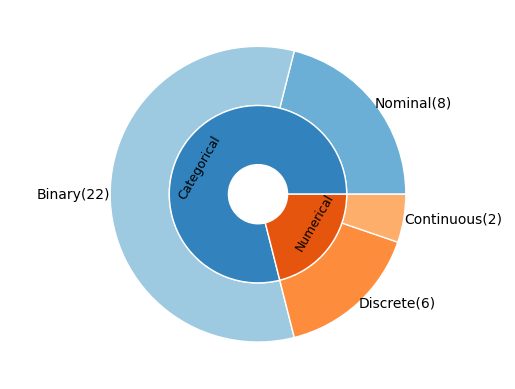

In [5]:
# Nested pie-chart to see the proportion of variables based on their type
group_names = ["Categorical","Numerical"]
group_sizes = [ 8+22,6+2] 

subgroup_names = ["Nominal(8)", "Binary(22)","Discrete(6)", "Continuous(2)" ]
subgroup_sizes = [8, 22,6, 2]

fig, ax = plt.subplots()
ax.axis('equal')
width = 0.4

# Outer ring
cm = plt.get_cmap("tab20c")
cout = cm(np.array([1,2,5,6,9,10]))
pie, _ = ax.pie(subgroup_sizes, labeldistance=1,radius=1, labels=subgroup_names, colors=cout)
plt.setp(pie, width=width, edgecolor='white')

# Inner ring
cin = cm(np.arange(3)*4)
pie2, _ = ax.pie(group_sizes, radius=1-width, labels=group_names,textprops={'rotation':60, 'fontsize':9, 'color':'black'},
                 labeldistance=0.5, colors=cin)
plt.setp(pie2, width=width, edgecolor='white')
plt.show()

The nested (donut) chart above illustrates the distribution of dataset features by their types and subtypes. The inner ring categorizes them into two primary groups — Categorical and Numerical, while the outer ring provides a more detailed breakdown of these groups.

### 1.2 Target variable (Label):
The target variable is damage_grade (type:Ordinal, datatype:int64]), which represents a level of damage to the building that was hit by the earthquake. There are 3 grades of the damage:

    1 : Low damage
    2 : Medium damage
    3 : Almost Complete destruction



## 2. Data Preparation

#### 2.1  Merge and Handling Duplicates

The dataset of the train_values and train_labels were merged based on the unique identifier to support data exploration.

After merging, the dataset was checked for duplicate rows, meaning rows where all the feature values are exactly the same as another row. The check revealed that there were 12,319 duplicate rows. All these duplicate rows were removed from the dataset so that only unique rows remained.

We were careful not to blindly remove the duplicate rows since the same area may truly contain buildings with identifical features. The decision to remove the duplicates was made to redude redundancy and avoid data leakage during the model training, ensuring that the train and test sets remain independent.


In [6]:
# Merge features and labels
data_merged = pd.merge(data_raw, label_raw, on='building_id', how='inner')

# Drop duplicates based on all columns except 'building_id'
merged_clean = data_merged.drop_duplicates(subset=[col for col in data_merged.columns if col != 'building_id'])

print(f"Removed {len(data_merged) - len(merged_clean)} duplicate rows.")
print(f"Cleaned data shape: {merged_clean.shape}")

# Separate data and label again after removing duplicates
label = merged_clean[['building_id', 'damage_grade']].copy()
data = merged_clean.drop(columns=['damage_grade'])



Removed 12319 duplicate rows.
Cleaned data shape: (248282, 40)


#### 2.2. Checking NaN values

The dataset was scanned for missing values (NaNs) in all columns to identify incomplete entries as most machine learning algorithms cannot process NaN values. The check shows that the dataset is fully complete with no missing entries.

In [7]:
total_nans = merged_clean.isna().sum().sum()
print(f"Total NaN values: {total_nans}")

Total NaN values: 0


## 3. Data Analysis

#### 3.1. Target Label Distribution

To see the distribution of observation with each target category, we created a bar chart, as shown in the figure below. The difference in the heights between the dataset are due to variations in the number of observations for each target.  It is obvious that there is an imbalance, where the majority class is the 'Medium Damage' and the  minority class 'Low Damage'. 

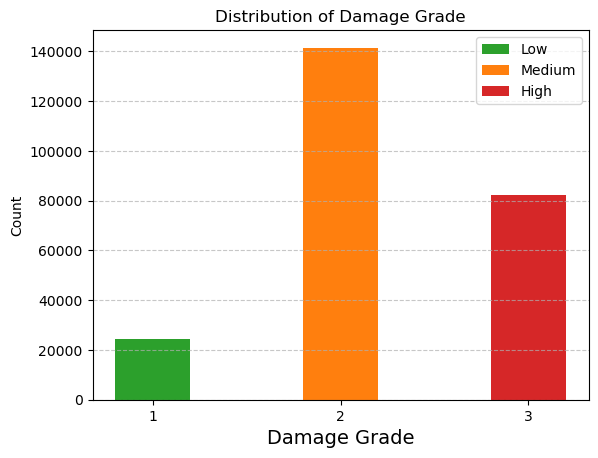

In [8]:
# Histogram plot of Label data

fig, ax = plt.subplots()
value_count_result= label["damage_grade"].value_counts().sort_index()
grades = value_count_result.index.tolist()
counts = value_count_result.values.tolist()

bar_labels = ['Low', 'Medium', 'High']
bar_colors = ['tab:green', 'tab:orange', 'tab:red']

ax.bar(grades, counts, label=bar_labels, color=bar_colors,width=0.4)
ax.set_xticks(grades)
ax.set_ylabel('Count')
ax.set_xlabel("Damage Grade", fontsize=14)
ax.set_title('Distribution of Damage Grade')
ax.grid(axis="y", linestyle="--", alpha=0.7)
ax.legend() #title='Damage Grade'
plt.show()

### 3.2. Featues Distribution

The list of columns is organized based on feature categories i.e. categorical, numerical and binary.  This categorization helps in applying appropriate preprocessing, encoding, and analysis techniques tailored to each feature type afterwards.


In [9]:
# Defining the list of columns based on feature categories
numerical_columns = [
    "age",
    "count_floors_pre_eq",
    "area_percentage",
    "count_families",
    "height_percentage",
    "geo_level_1_id",
    "geo_level_2_id",
    "geo_level_3_id",
]

categorical_columns = [
    "land_surface_condition",
    "foundation_type",
    "roof_type",
    "ground_floor_type",
    "other_floor_type",
    "position",
    "plan_configuration",
    "legal_ownership_status"]

binary_columns= [
    'has_superstructure_adobe_mud',
    'has_superstructure_mud_mortar_stone',
    'has_superstructure_stone_flag',
    'has_superstructure_cement_mortar_stone',
    'has_superstructure_mud_mortar_brick',
    'has_superstructure_cement_mortar_brick',
    'has_superstructure_timber',
    'has_superstructure_bamboo',
    'has_superstructure_rc_non_engineered',
    'has_superstructure_rc_engineered',
    'has_superstructure_other',
    'has_secondary_use',
    'has_secondary_use_agriculture',
    'has_secondary_use_hotel',
    'has_secondary_use_rental',
    'has_secondary_use_institution',
    'has_secondary_use_school',
    'has_secondary_use_industry',
    'has_secondary_use_health_post',
    'has_secondary_use_gov_office',
    'has_secondary_use_use_police',
    'has_secondary_use_other'
    ]

#### 3.2.1 Numerical Feature Distribution

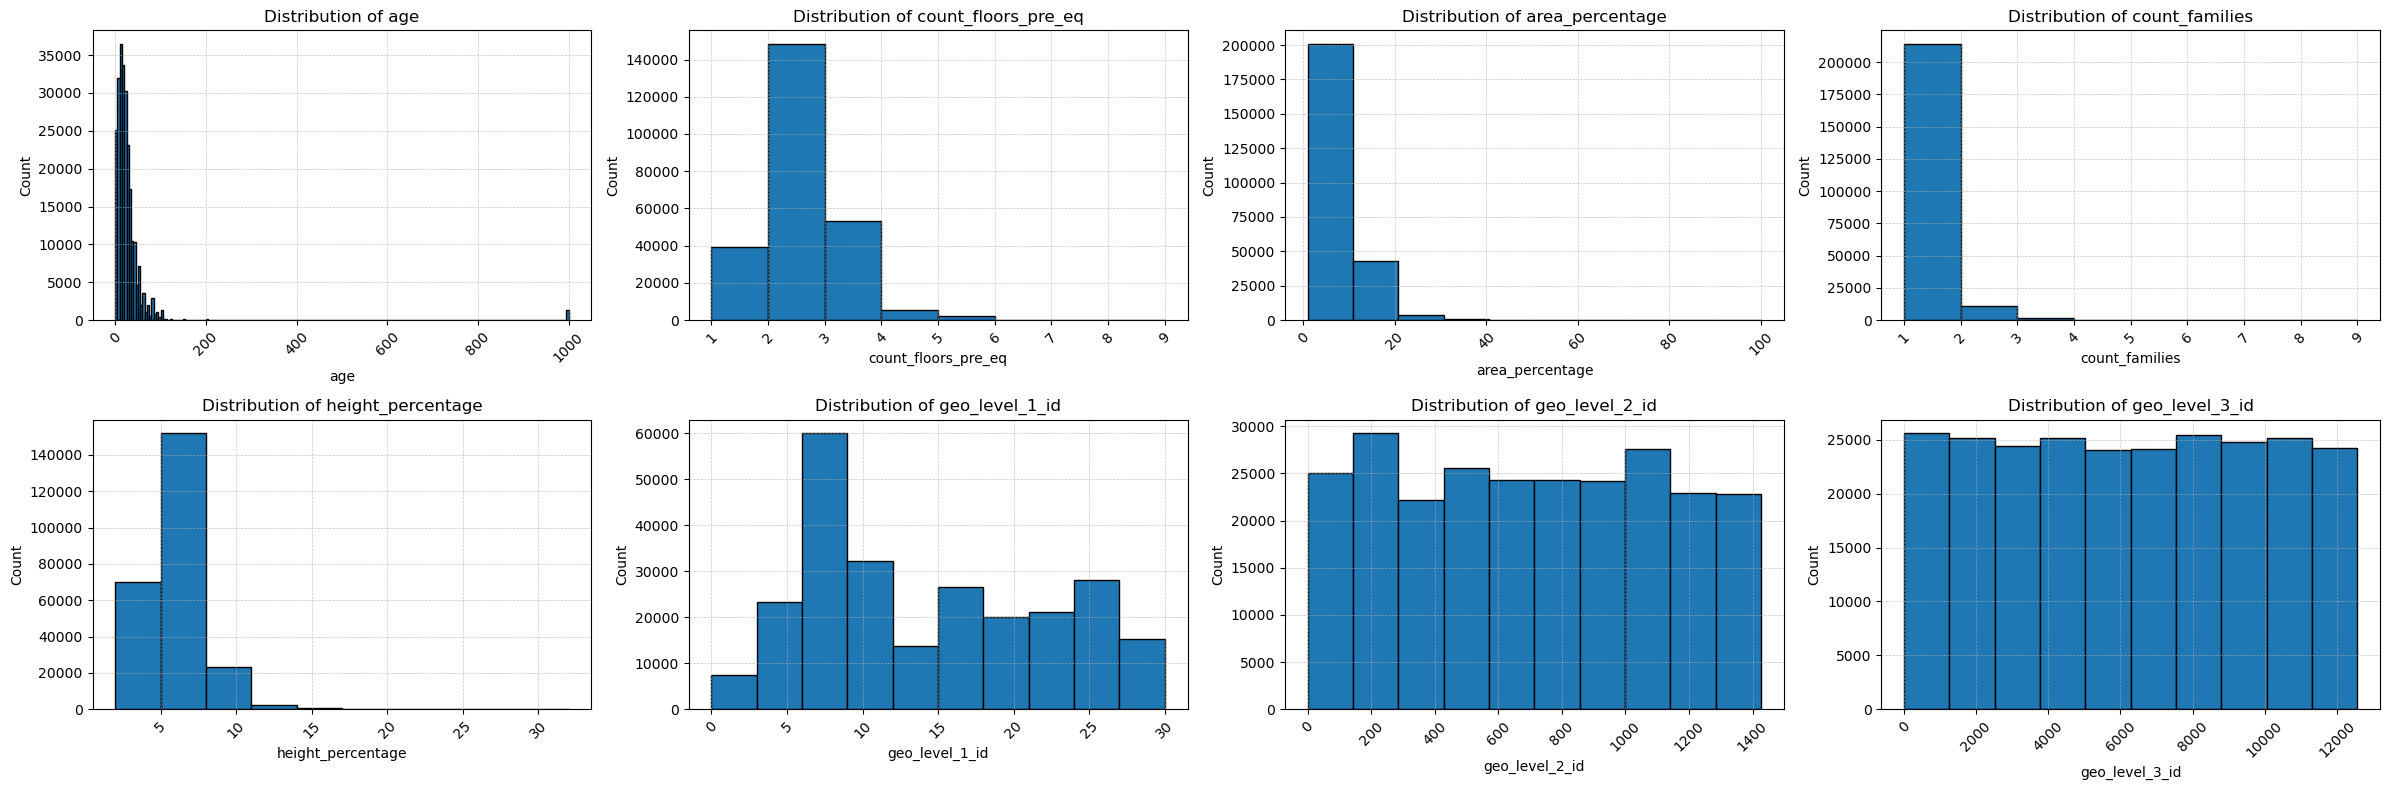

,age,count_floors_pre_eq,area_percentage,count_families,height_percentage,geo_level_1_id,geo_level_2_id,geo_level_3_id
count,248282.000000,248282.000000,248282.000000,248282.000000,248282.000000,248282.000000,248282.000000,248282.000000
mean,26.588859,2.128882,8.079672,0.983390,5.436971,13.910795,700.611466,6256.521270
std,72.694040,0.733440,4.451749,0.427352,1.931511,8.048979,412.969927,3644.721847
min,0.000000,1.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000
25%,10.000000,2.000000,5.000000,1.000000,4.000000,7.000000,349.000000,3073.000000
50%,15.000000,2.000000,7.000000,1.000000,5.000000,12.000000,701.000000,6264.000000
75%,30.000000,2.000000,10.000000,1.000000,6.000000,21.000000,1050.000000,9411.000000
max,995.000000,9.000000,100.000000,9.000000,32.000000,30.000000,1427.000000,12567.000000


In [10]:
n_cols = min(4, len(numerical_columns))  
n_rows = (len(numerical_columns) + n_cols - 1) // n_cols

# Create subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 6, n_rows * 4))
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

# Plot histograms
for idx, col in enumerate(numerical_columns):
    if col == 'age':
        bins = range(0, 1001, 5)  # 5-year intervals up to 1000
    elif col == 'count_floors_pre_eq':
        bins = range(1, 10,1)  # 1 to 10 floors
    elif col == 'count_families':
        bins = range(1, 10,1)  # 1 to 10 floors
    else:
        bins = 10  # Default 20 bins for other numerical columns

    data[col].hist(ax=axes[idx], bins=bins, color='#1f77b4', edgecolor='black', grid=True)
    axes[idx].set_title(f'Distribution of {col}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Count')
    axes[idx].grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    axes[idx].tick_params(axis='x', rotation=45)

# Remove empty subplots
for idx in range(len(numerical_columns), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

data[numerical_columns].describe()

**Analysis:**

The above histogram displays the distribution of numerical features in a dataset. 
Most features (age, count_floors_pre_eq, area_percentage, count_families, height_percentage) are right-skewed, indicating that lower values are more common. The geo_level_1_id have distinct peaks, while geo_level_2_id and geo_level_3_id is more uniform. 

Based on this, we assume that geo_level_1_id represents different municipalities or local administrative areas where the earthquake occurred, while geo_level_3_id likely corresponds to a broader regional or national-level classification.

For the age feature, we observed that the values increase sharply from around 200 to 995. These high values do not appear to be outliers but may represent grouped records or aggregated building ages. It is also possible that these values are valid and correspond to very old or historically significant structures. 

In summary, since we are are working with real field data collection and due to the type of event we are looking at, we assume that extreme values is most likely to be genuine rather than outliers. We made the decision therefore to keep them.

#### 3.2.2 Categorical Features Distribution

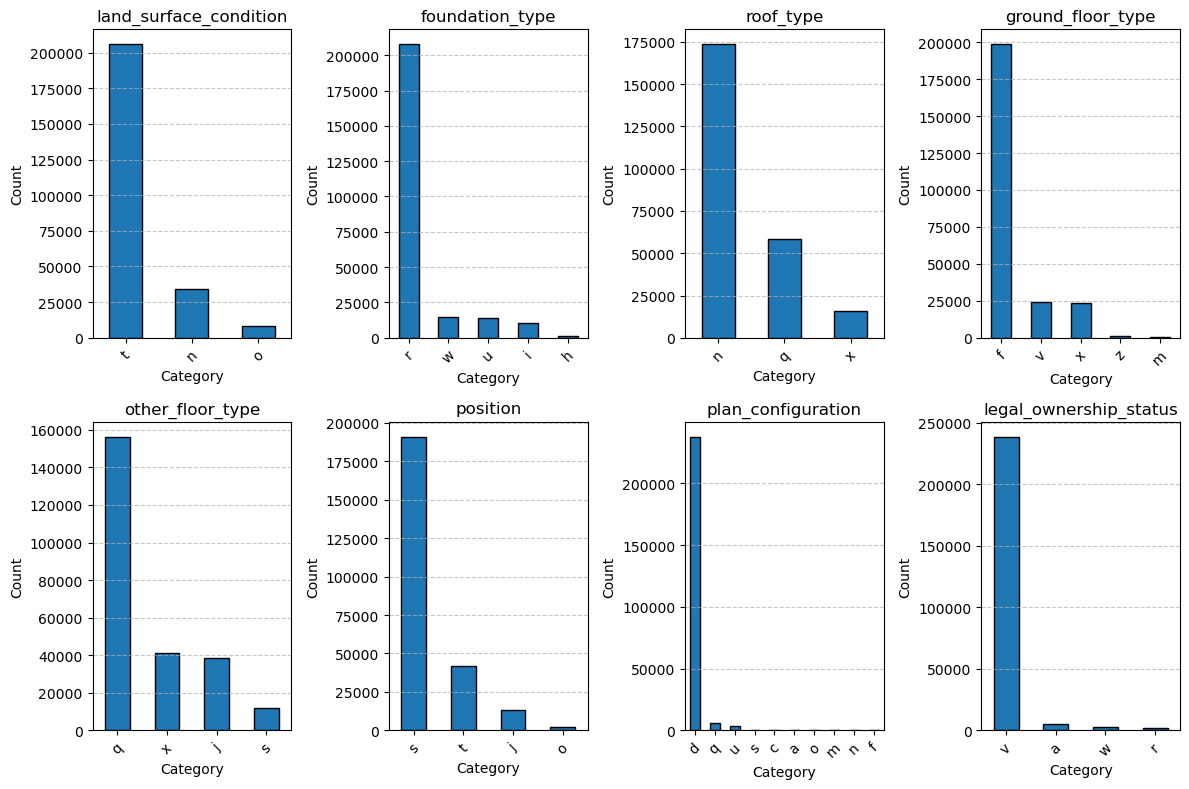

**-- Categorical columns with their categories and corresponding counts --**
land_surface_condition
t    206049
n     34246
o      7987
Name: count, dtype: int64
foundation_type
r    207900
w     14463
u     14032
i     10468
h      1419
Name: count, dtype: int64
roof_type
n    173780
q     58471
x     16031
Name: count, dtype: int64
ground_floor_type
f    198750
v     24200
x     23860
z       970
m       502
Name: count, dtype: int64
other_floor_type
q    156440
x     41226
j     38651
s     11965
Name: count, dtype: int64
position
s    191164
t     41777
j     13046
o      2295
Name: count, dtype: int64
plan_configuration
d    237906
q      5549
u      3641
s       346
c       324
a       251
o       159
m        46
n        38
f        22
Name: count, dtype: int64
legal_ownership_status
v    238949
a      5287
w      2591
r      1455
Name: count, dtype: int64


In [11]:
# Create subplots
n_cols=4
fig, axes = plt.subplots(nrows=math.ceil(len(categorical_columns) / n_cols), ncols=n_cols, figsize=(12, 8))
axes = axes.flatten()

# Plot each categorical column
for idx, col in enumerate(categorical_columns):
    data[col].value_counts().plot(kind='bar', ax=axes[idx], color='#1f77b4', edgecolor='black')
    axes[idx].set_title(col)
    axes[idx].set_xlabel("Category")
    axes[idx].set_ylabel("Count")
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(axis="y", linestyle="--", alpha=0.7)

# Adjust layout and remove unused subplots
plt.tight_layout()
for idx in range(len(categorical_columns), len(axes)):
    fig.delaxes(axes[idx])

plt.show()

print("**-- Categorical columns with their categories and corresponding counts --**")
for col in categorical_columns:
    print(data[col].value_counts())

**Analysis:** 

The bar plots illustrate the distribution of categorical features, with categories shown on the x-axis and their corresponding frequencies on the y-axis.
The dataset shows strong class imbalance across all features, with one category per feature having a significantly higher count (greater than 175,000) compared to others.

#### 3.2.3 Binary Feature Distribution

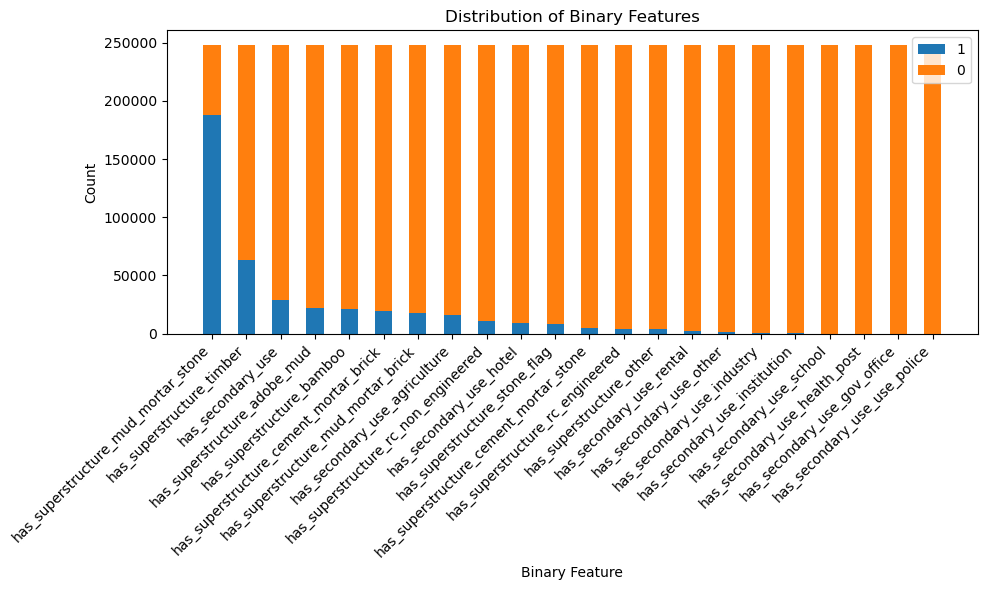

,Feature,Count_0,Count_1,%_0,%_1
0,has_superstructure_mud_mortar_stone,60461,187821,24.35,75.65
1,has_superstructure_timber,184810,63472,74.44,25.56
2,has_secondary_use,219541,28741,88.42,11.58
3,has_superstructure_adobe_mud,225921,22361,90.99,9.01
4,has_superstructure_bamboo,227050,21232,91.45,8.55
5,has_superstructure_cement_mortar_brick,229047,19235,92.25,7.75
6,has_superstructure_mud_mortar_brick,230887,17395,92.99,7.01
7,has_secondary_use_agriculture,231881,16401,93.39,6.61
8,has_superstructure_rc_non_engineered,237350,10932,95.60,4.40
9,has_secondary_use_hotel,239544,8738,96.48,3.52


In [12]:
def plot_binary_distribution(columns,dataset, title):
    """
    columns: list of column
    dataset: pandas dataframe of the dataset
    title: title of the chart
    """

    # --- Count 0s and 1s for each binary column ---
    counts_0 = dataset[columns].apply(lambda x: (x==0).sum())
    counts_1 = dataset[columns].apply(lambda x: (x==1).sum())
    # --- Sort features by number of 1s ---
    sorted_cols = counts_1.sort_values(ascending=False).index
    counts_0 = counts_0[sorted_cols].to_numpy()
    counts_1 = counts_1[sorted_cols].to_numpy()

    # --- Plot stacked bar chart using the template ---
    width = 0.5
    fig, ax = plt.subplots(figsize=(10,6))
    bottom = np.zeros(len(sorted_cols))

    for lab, count in zip(["1", "0"], [counts_1, counts_0]):
        ax.bar(sorted_cols, count, width, label=lab, bottom=bottom)
        bottom += count  # stack bars

    ax.set_title(title)
    ax.legend(loc="upper right")
    ax.set_ylabel("Count")
    ax.set_xlabel("Binary Feature")
    plt.xticks(rotation=45,ha='right')
    plt.tight_layout()
    plt.show()

    # --- Create table of counts ---
    count_df = pd.DataFrame({
        "Feature": sorted_cols,
        "Count_0": counts_0,
        "Count_1": counts_1
    })

    # Calculate total and percentages
    count_df["Total"] = count_df["Count_0"] + count_df["Count_1"]
    count_df["%_0"] = (count_df["Count_0"] / count_df["Total"] * 100).round(2)
    count_df["%_1"] = (count_df["Count_1"] / count_df["Total"] * 100).round(2)

    # Reset index for neat display
    count_df = count_df.drop(columns="Total")

    display(count_df)

    return sorted_cols

_ = plot_binary_distribution(binary_columns,data, "Distribution of Binary Features")

**Analysis:**

The bar plot displays the distribution of binary features in the dataset, with blue representing the count of samples with values 1 and orange for 0. 
The dataset exhibits strong class imbalance across nearly all binary features, with 0 as dominating class.

Columns (14-21 in the table) has very low occurrence of 1 (i.e <1%). As these features might not help in model training, we can drop them to  reduce noise, and speed up training. But this feature might also play important role in training, so we will train the model by removing those columns and and also with the columns. If it is not contributing, we will drop the columns.

## 4. Pre-processing Data

### 4.1 Check Correlation between Numerical Features

Checking the correlation between numerical features is an important step in data preprocessing. This information might be helpful to reduce redundancy and improve model performance. In our dataset, we computed a correlation matrix for numerical features as follows.


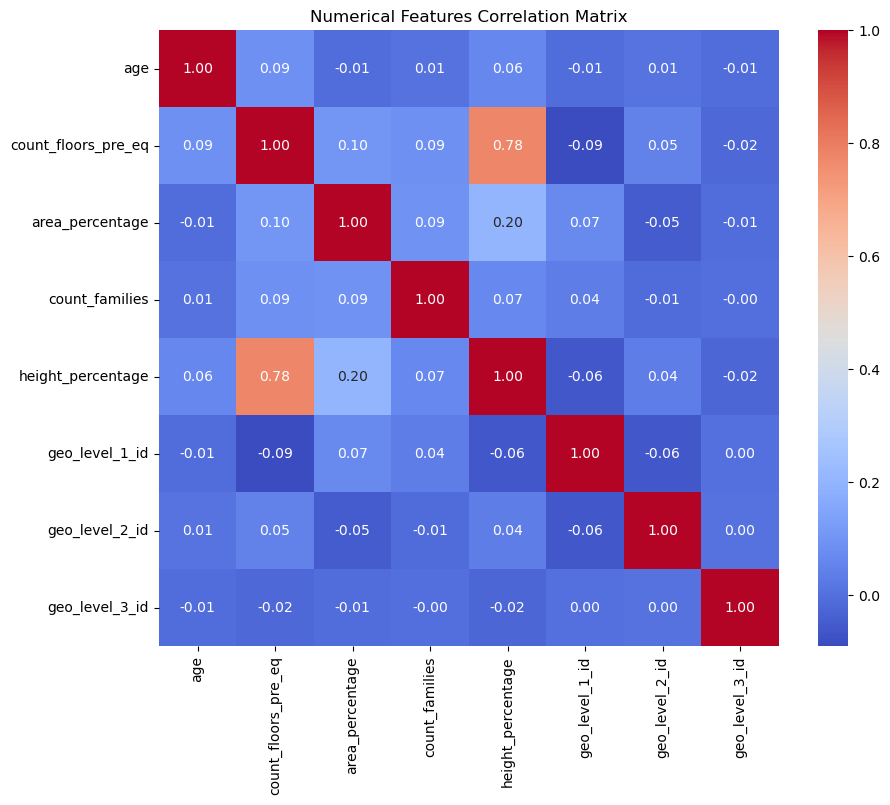

In [13]:
corr_matrix = data[numerical_columns].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Numerical Features Correlation Matrix")
plt.show()


**Analysis:**

The image shows a Binary Feature Correlation Matrix, which displays the Pearson correlation coefficients between pairs of numerical features in the dataset. The matrix is a square grid where each cell represents the correlation between two features, with values ranging from -1 (perfect negative correlation) to 1 (perfect positive correlation).
There is  strong correlation (0.78) between count_floors_pre_eq and height_percentage. Therefore, We remove height_percentage feature to reduce redundancy, prevent multicollinearity, and simplify the model for better performance.

In [14]:
"""
# removing height_percentage feature
# data=data.drop(columns=["height_percentage"])
"""

'\n# removing height_percentage feature\n# data=data.drop(columns=["height_percentage"])\n'

### 5.4 Train-Test Data Splitting

The dataset is split into training and testing sets using an 80:20 ratio. The dataset is highly imbalanced, therefore we apply the stratified splitting technique based on the target variable to ensure that the class distribution is preserved in both train and test sets. 

X_train / y_train → used to train the model

X_test / y_test → used to evaluate the model’s performance on unseen data

In [15]:
data_only=data.drop(columns=['building_id'])
label_only=label.drop(columns=['building_id'])

X_train, X_test, y_train, y_test = train_test_split(
    data_only, label_only, test_size=0.2, random_state=42, stratify=label_only
)

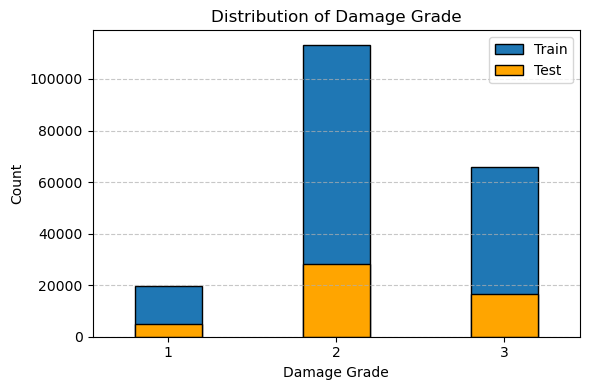

In [16]:
fig, ax = plt.subplots(figsize=(6, 4))

y_train['damage_grade'].value_counts().sort_index().plot(
    kind='bar',
    ax=ax,
    color='#1f77b4',
    edgecolor='black',
    width=0.4,
    label='Train'
)

y_test['damage_grade'].value_counts().sort_index().plot(
    kind='bar',
    ax=ax,
    color='#FFA500',
    edgecolor='black',
    width=0.4,
    label='Test'
)

ax.set_title("Distribution of Damage Grade", fontsize=12)
ax.set_xlabel("Damage Grade")
ax.set_ylabel("Count")
ax.tick_params(axis='x', rotation=0)
ax.grid(axis="y", linestyle="--", alpha=0.7)
ax.legend()

plt.tight_layout()
plt.show()

**Analysis:**

The figure is a stacked bar plot illustrating the distribution of the target variable "Damage Grade" (categories 1, 2, and 3) across the training set (blue) and test set (orange). 
It is based on stratified splitting approach. Therefore, we can see similar proportions between the train and test sets which preserves the original dataset's class distribution.


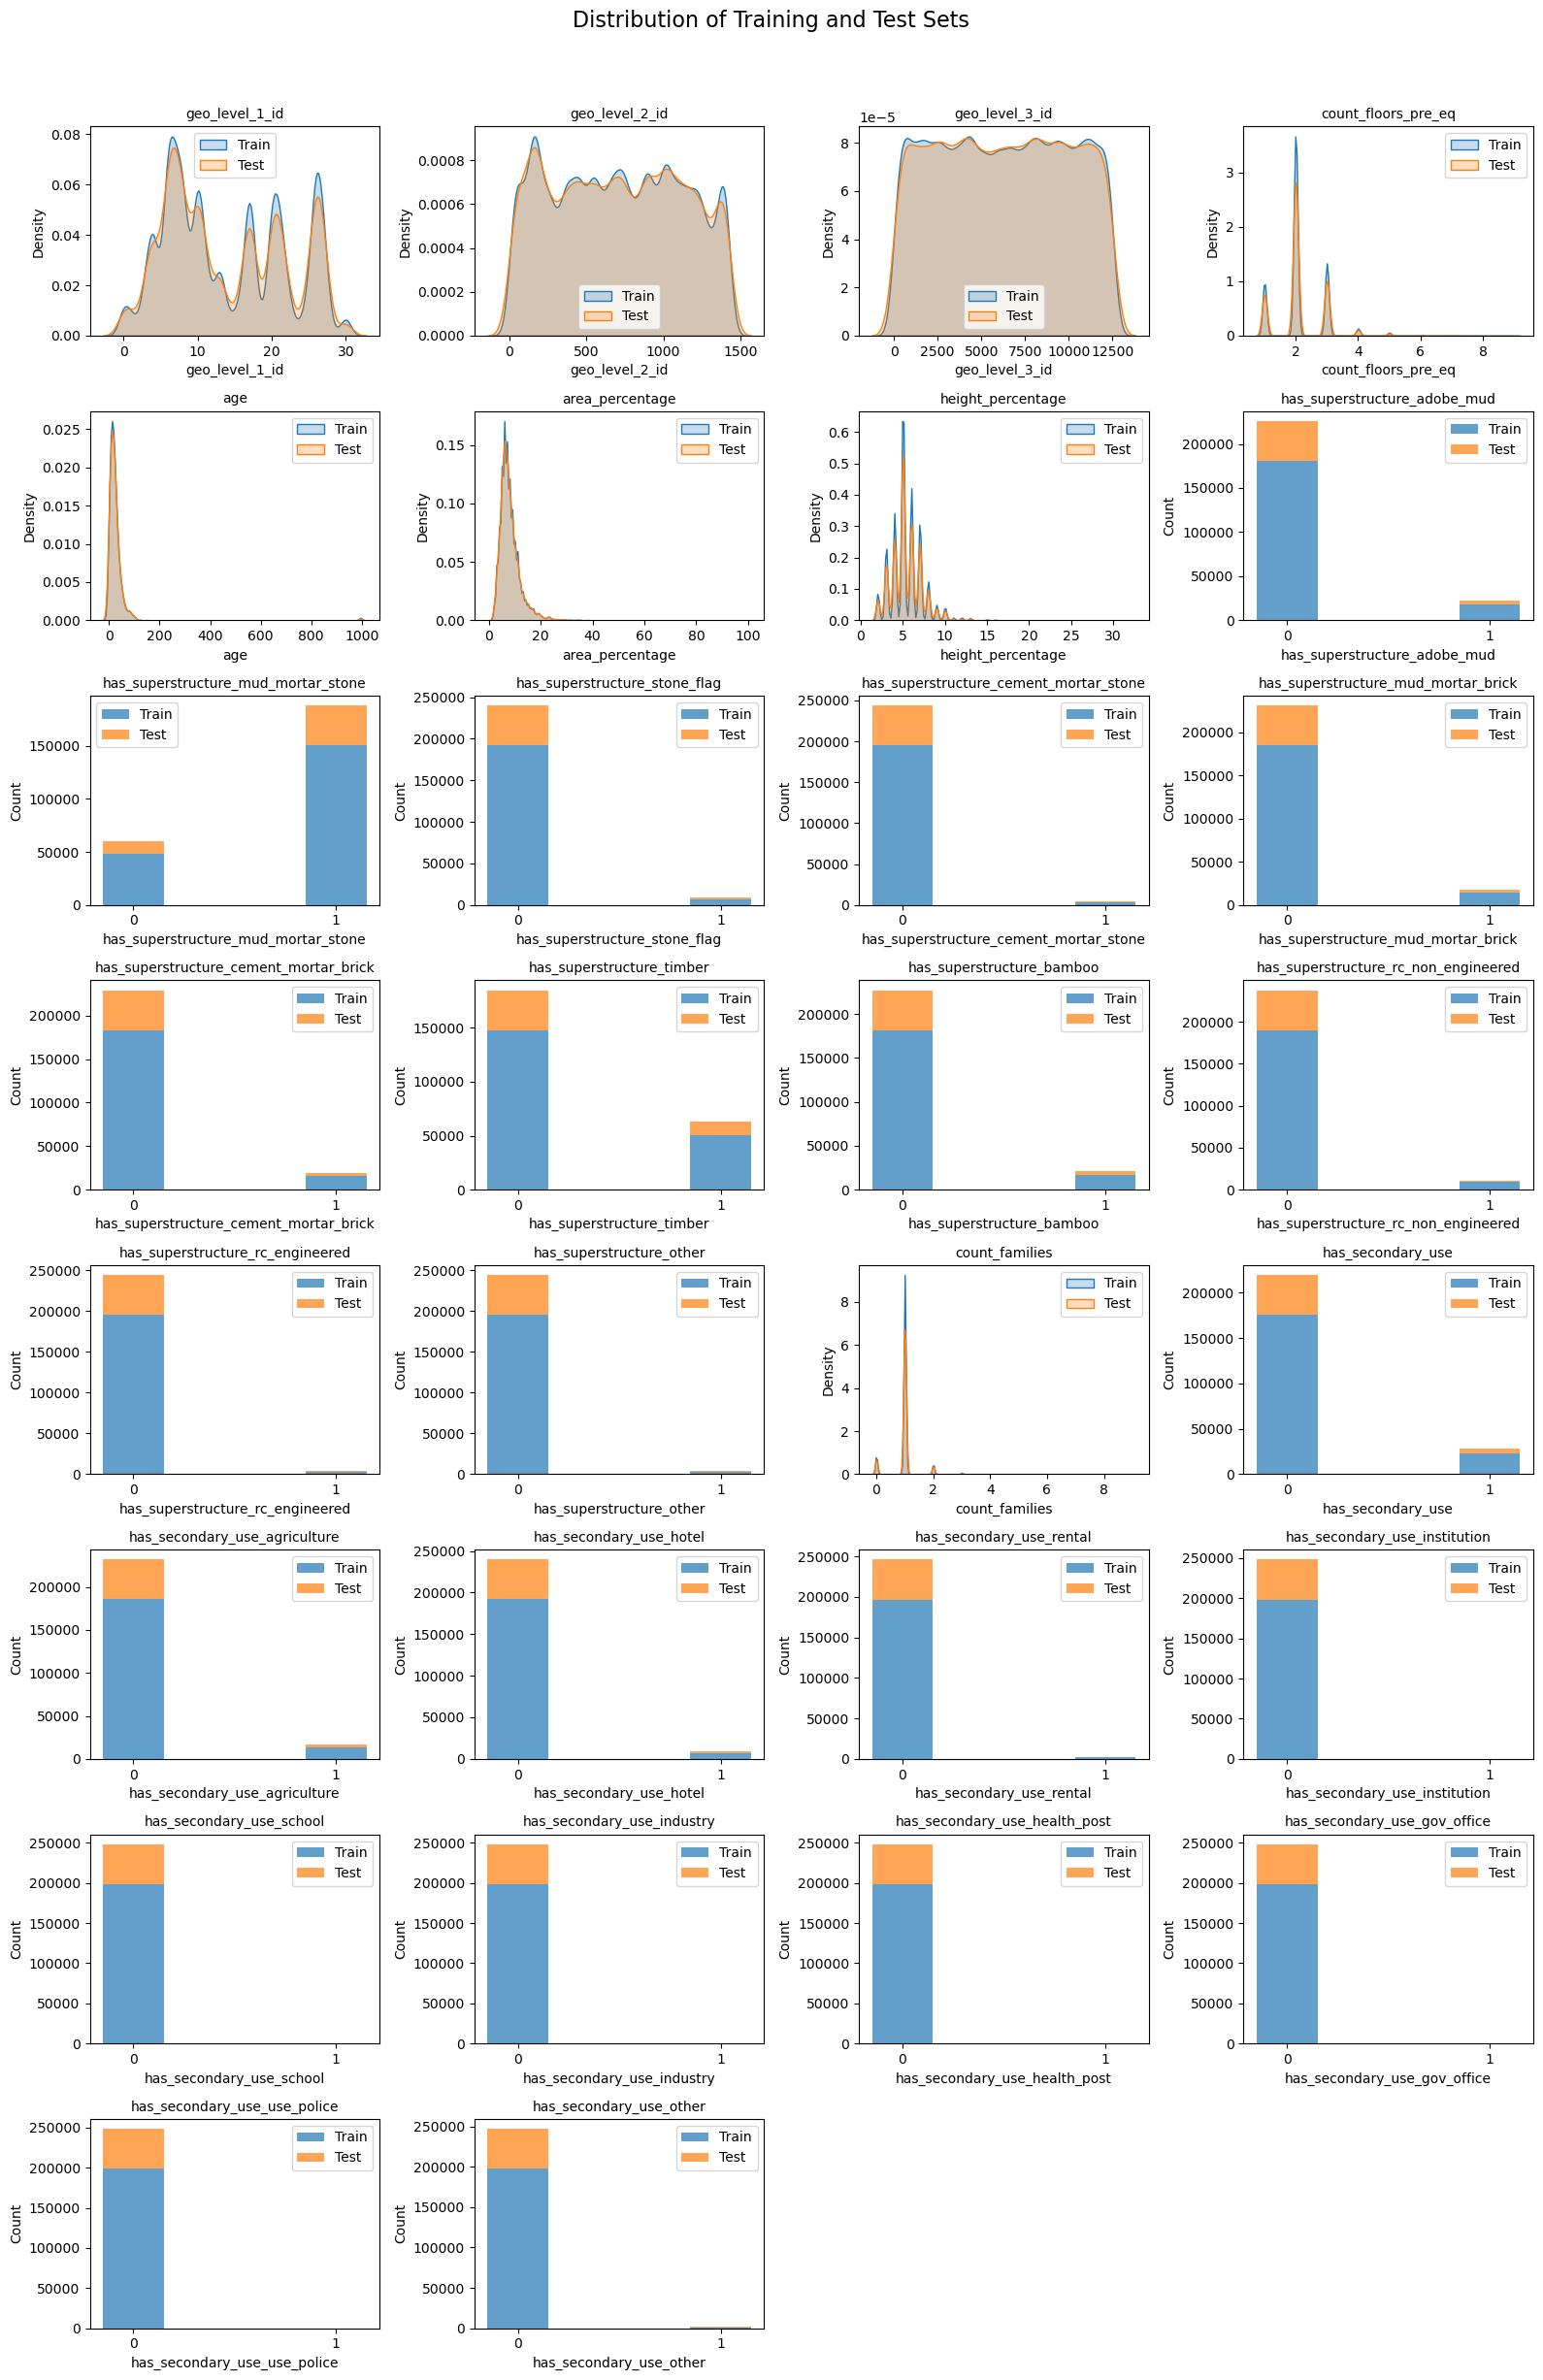

                         Feature  Count_1_Train  Count_1_Test
0       has_secondary_use_rental           1674           431
1  has_secondary_use_institution            202            43
2       has_secondary_use_school             76            18
3     has_secondary_use_industry            222            55
4  has_secondary_use_health_post             37            12
5   has_secondary_use_gov_office             30             8
6   has_secondary_use_use_police             21             2


In [17]:
# Select only numerical columns
numeric_train = X_train.select_dtypes(include=['int64', 'float64'])
numeric_test = X_test.select_dtypes(include=['int64', 'float64'])

num_features = len(numeric_train.columns)
n_cols = 4
n_rows = math.ceil(num_features / n_cols)

# Create subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(4*n_cols, 3*n_rows))
fig.suptitle('Distribution of Training and Test Sets', fontsize=16, y=1.02)

# Flatten axes for simpler iteration
axes = axes.flatten()
binary_summary=[]

for i, (var_name, var_data) in enumerate(numeric_train.items()):
    ax = axes[i]

    # Detect if column is binary (only 0 and 1)
    unique_vals = sorted(var_data.dropna().unique())
    is_binary = len(unique_vals) == 2 and set(unique_vals) <= {0, 1}

    selected_binary_columns= [
    'has_secondary_use_rental',
    'has_secondary_use_institution',
    'has_secondary_use_school',
    'has_secondary_use_industry',
    'has_secondary_use_health_post',
    'has_secondary_use_gov_office',
    'has_secondary_use_use_police',
    ]


    if is_binary:
        # Get counts for 0 and 1 in train/test sets
        train_counts = var_data.value_counts().sort_index()
        test_counts = numeric_test[var_name].value_counts().sort_index()

        if var_name in selected_binary_columns:
            count_0_train = train_counts.get(0, 0)
            count_1_train = train_counts.get(1, 0)
            
            # Get counts for test
            count_0_test = test_counts.get(0, 0)
            count_1_test = test_counts.get(1, 0)
            
            # Append to summary list
            binary_summary.append({
                "Feature": var_name,
                # "Count_0_Train": count_0_train,
                "Count_1_Train": count_1_train,
                # "Count_0_Test": count_0_test,
                "Count_1_Test": count_1_test
            })

        # Create stacked bar plot
        x = [0, 1]
        ax.bar(x, train_counts, label='Train', alpha=0.7, color='#1f77b4', width=0.3)
        ax.bar(x, test_counts, bottom=train_counts, label='Test', alpha=0.7, color='#ff7f0e', width=0.3)

        ax.set_xticks([0, 1])
        ax.set_xticklabels(['0', '1'])
        ax.set_xlabel(var_name)
        ax.set_ylabel("Count")
        ax.set_title(f"{var_name}", fontsize=10)
        ax.legend()
    else:
        # KDE plot for continuous variables
        sns.kdeplot(var_data, ax=ax, label='Train', fill=True)
        sns.kdeplot(numeric_test[var_name], ax=ax, label='Test', fill=True)
        ax.set_xlabel(var_name)

    ax.set_title(var_name, fontsize=10)
    ax.legend()


# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

# Create dataframe to plot the count of selected binary features
selected_count_df = pd.DataFrame(binary_summary)

print(selected_count_df)


**Analysis:**

To check if the distribution of the training and test sets are similar, kernel density plot was plotted for numerical variables and stacked bar plot for the binary fearures.
These plots indicate that most of the features are similarly distributed between Train and Test sets, supporting the use of a stratified sampling method.
But, for few binary features that has highly dominating 0 values (i.e. less than 1% values of 1), the splits is not visible in plots above. Therefore, the Count of "1" is displyed in table above for the selected columns. 




### 5.2  Encoding Categorical Variables

For the categorical variables, we applied one-hot encoding to transform them into numeric form. Since most machine learning algorithms require numerical input, this transformation allows the model to effectively interpret and learn from categorical data without assuming any ordinal relationship between the categories. 

After encoding, the original 8 categorical variables expanded into 38 binary features. This approach works well because it preserves all category information while ensuring that each category is treated independently.

In [18]:
# X_train_cat = X_train[categorical_columns]

# encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
# X_train_encoded = encoder.fit_transform(X_train_cat)

# X_train_merge=X_train.drop(columns=categorical_columns)
# # Merge encoded columns with the rest of the data
# X_train_new = pd.concat([X_train_merge, X_train_encoded], axis=1)

# print(f"Number of categorical columns: {len(categorical_columns)}")
# print(f"Number of encoded categorical columns: {X_train_new.shape[1]-X_train_merge.shape[1]}")
# print(f"Final shape after encoding: {X_train_new.shape}")

In [19]:
# one_hot_encoded_columns=list(X_train_encoded.columns)
# sorted_cols= plot_binary_distribution(one_hot_encoded_columns,X_train_new,"Distribution of One-hot Encoded Categorical Features" )



**Analysis**

The stacked bar chart above illustrates the distribution of the one-hot encoded features. The accompanying table presents the counts of 0’s and 1’s, along with their respective percentages. Among the 38 features, 12 have 1’s in less than 1% of the cases. Consequently, in the subsequent analysis, MCA is computed twice: once including all encoded features, and once excluding the features with less than 1% of 1’s.

In [20]:
# list of the features that has 1's less than 1%
# less_imp_cols=['position_o','legal_ownership_status_r','foundation_type_h','ground_floor_type_z','ground_floor_type_m','plan_configuration_s','plan_configuration_c',
# 'plan_configuration_a', 'plan_configuration_o','plan_configuration_m','plan_configuration_n','plan_configuration_f']
# encoded_cols=sorted_cols

# # X_train after removing less important columns
# X_train_encoded_refined=X_train_encoded.drop(columns=less_imp_cols)


### 5.3 Applying Multiple Correspondence Analysis (MCA)

After one-hot encoding the categorical variables, the dataset becomes high-dimensional because each category is expanded into its own binary column. To address this, we apply Multiple Correspondence Analysis (MCA) a dimensionality reduction technique designed specifically for categorical data. 

We use the prince library to compute the MCA.

In [21]:
# # Function to compute and plot MCA components
# def compute_plot_mca(data, n_components, title):
#     mca = prince.MCA(
#         n_components=n_components,
#         n_iter=3,
#         copy=True,
#         # one_hot=False,
#         check_input=True,
#         engine='sklearn',
#         random_state=42
#     )
#     mca = mca.fit(data)

#     # Get eigenvalues and total inertia
#     eigvals = mca.eigenvalues_        # array of eigenvalues
#     total_inertia = mca.total_inertia_  # total inertia

#     # Compute inertia
#     explained_inertia = eigvals / total_inertia
#     cumulative_inertia = np.cumsum(explained_inertia)

#     print("Inertia per component:", explained_inertia)
#     print("Cumulative explained inertia:", cumulative_inertia)

#     plt.plot(range(1, len(explained_inertia)+1), explained_inertia, marker='o')
#     plt.xlabel("Component")
#     plt.ylabel("Inertia")
#     plt.title(title)
#     plt.show()
#     return mca

# # _ = compute_plot_mca(X_train_encoded,9, "MCA Plot (All Encoded Columns)")
# mca= compute_plot_mca(X_train_encoded_refined,9, "MCA Plot")

# '''
# X_train_cat = X_train[categorical_columns]
# mca= compute_plot_mca(X_train_cat,9, "MCA Plot.....")
# '''


The two plots above represent the Multiple Correspondence Analysis (MCA) scree plots, showing the proportion of explained inertia (variance) for each component. The first plot was computed using all the one-hot encoded categorical features, while the second plot was generated after removing less informative features. We observe that the highest variation in the data is concentrated in the first 2-3 components while the later one contributes very little additional information. 

We included both plots to illustrate the impact of features on the explained variance. Initially, when all encoded categorical features were used, the first 9 components accounted for only about 39% of the total variance, suggesting that some features contributed little to the overall structure of the data.

To improve the representation of the data and capture more meaningful variance, we removed twelve features that contained mostly zero values (i.e., categories with minimal or no variation). This refinement reduced noise by removing the uninformative features.



In [22]:
# #Applying MCA in X_train
# mca_components = mca.transform(X_train_encoded_refined)

# #remove encoded columns
# X_train_encoded_removed=X_train_new.drop(columns=encoded_cols)

# # mca, mca_components = compute_plot_mca(X_train_encoded_refined, "MCA Plot")
# X_train_final = pd.concat([X_train_encoded_removed, mca_components], axis=1)

# print(f"Shape after removing encoded columns and adding MCA components: {X_train_final.shape}")


#### 5.4  Computimg the correlation between Features and the Damage Grade

Our initial analysis confirms that the training and the testing datastes have similar distribution. We use the training dataset for further data analysis 

To assess the correlation among all the features, we generate a correlation matrix plot using a heatmap of Spearman correlations. Given that the target variable is an ordinal category, the Spearman correlation serves the best purpose to show this relationship. We use the one-hot encoding representation of the categorical data to ensure proper statistical analysis. This helped us visually identify any strong or weak correlation that could influence the model training.

None of the variables show a positive or negative correlation greater than 0.3. It may be hard to draw any conclusion regarding the importance of these variable in determining the damage grade. However, we observe that a few features, such as foundation_type_r, superstructure_mortar_stone show moderate positive correlation, which is worth mentioning. 

In [23]:
# train_data = X_train_final.copy()
# train_data['damage_grade'] = y_train

# plt.figure(figsize=(4, 15))
# heatmap = sns.heatmap(train_data.corr(method='spearman')[['damage_grade']].sort_values(by='damage_grade', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
# heatmap.set_title('Correlation values between Features and Damage Grade', fontdict={'fontsize':18}, pad=16)

# 6. Proposed Protocol

**a. Data Spliting Strategy and Preventing Data Leakage**

The initial dataset is splited into 80% for training and 20% for testing, following the standard Ml procedure. 
From our analysis, we see that the dataset is heavily imbalanced, therefore we chose stratified sampling method. To prevent data leakage and ensure good generalization on unseen data, we carefully design the data-splitting protocol. All preprocessing steps such as encoding categorical variables and applying Multiple Correspondence Analysis (MCA) are performed only on the trainign set after splitting to avoid leakage.

Considering the features are highly imbalanced, we will focus on selecting models that is capable of dealing with this kind of problem and learning from the data efficiently.  The same transformations fitted on the training sets will be applied to the test sets to ensure consistency and to properly evaluate the model’s performance.

**b. Model Training**

Looking at the data, we make an assumption that features (numerical: families_count, distribution of geolevel-2, distribution of geolevel-3, categorical: plan, position_configuration, legal_ownership_staus) has no direct relation to the Eathquake building damage classification problem. We verify this based on feature correlation with target variables heatmap. We will train two versions of the model: one excluding these features and another including them, to assess their impact on model performance and evaluation.

In addition to this, the binary features with the count of 1's less than 1% of the data, will also be examined.  Such features will be excluded if they show minimal contribution after model training.

**c. Hyperparameters Tuning**

For hyperparameter tuning, only the training data will be used—either by splitting it into training and validation subsets or by applying stratified k-fold cross-validation, depending on the model. The choice of tuning strategy will be made after selecting the model, as it depends on the number and complexity of parameters to be optimized.

**d. Evaluation metric**

Since our task involves multi-class classification, we will use the macro F1 score as the primary evaluation metrics. The macro F1 score calculates the F1 score independently for each class and then takes the unweighted average, thus giving equal importance to all classes, regardless of their frequency in the dataset. This makes it particularly suitable for imbalanced datasets, where some classes may be underrepresented.

In addition to the macro F1 score, we will also report the F1 score for each individual class. This will provide a more detailed view of the model’s performance across different categories and help identify specific classes where the model may be underperforming.


In [24]:
# Question
# MCA, does removing column make sense??


# X_train_final, y_train
# X_train_reduced, y_train
# X_test, y_test



### Transformer

In [25]:
binary_col_drop=[
    "has_secondary_use_agriculture", 
    "has_secondary_use_hotel",
    "has_secondary_use_rental",
    "has_secondary_use_institution",
    "has_secondary_use_school",
    "has_secondary_use_industry",
    "has_secondary_use_health_post",
    "has_secondary_use_gov_office",
    "has_secondary_use_use_police",
    "has_secondary_use_other"]
# numerical_col_drop=["height_percentage"]
# numerical_col_drop=[]


# X_train_reduced=X_train.copy().drop(columns=binary_col_drop)

mca_config = prince.MCA(
        n_components=9,
        n_iter=3,
        copy=True,
        # one_hot=False,
        check_input=True,
        engine='sklearn',
        random_state=42
    )

preprocess = ColumnTransformer([
    ('categorical', mca_config, categorical_columns),
     ('numerical', 'passthrough', numerical_columns) ,
      ('binary', 'passthrough', list(set(binary_columns)-set(binary_col_drop))) 
])

# preprocess_reduced=ColumnTransformer([
#     ('categorical', mca_config, categorical_columns),
#      ('numerical', 'passthrough', list(set(numerical_columns)-set(numerical_col_drop))) ,
#       ('binary', 'passthrough', list(set(binary_columns)-set(binary_col_drop))) 
# ])

### Dummy Classifier

### Random Forest

# HistGradientBoostingClassifier
HistGradientBoostingClassifier is scikit-learn’s fast, histogram-based gradient boosting classification tree model. It builds decision trees in a boosting framework using histogram binning, which makes it faster and more memory-efficient than GradientBoostingClassifier, especially for large datasets [HistGradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html) — *scikit‑learn* documentation.

**HistGradientBoostingClassifier — Parameters**

# HistGradientBoostingClassifier Parameters

**loss (default='log_loss')**: 

Loss function. Only option available for classification problems.  

**learning_rate (default=0.1)**: 

    Shrinkage factor for leaf values (range [0-1]); 1 means no shrinkage. 

**max_iter (default=100)**:   

    Maximum number of boosting iterations (i.e., trees) 

**max_leaf_nodes (default=31)**: 

    Maximum number of leaves per tree 

**max_depth (default=None)**:    

    Maximum depth of each tree; 'None' means unlimited  

**min_samples_leaf (default=20)**: 

    Minimum number of samples in a leaf

**l2_regularization (default=0.0)**: 

    Penalizes leaves with small Hessians; 0 means no regularization

**max_features (default=0.0)**: 

    Proportion of randomly chosen features in each node split

**max_bins (default=255)**: 

    Number of bins to discretize continuous features (speeds up training)

**categorical_features (default='from_dtype')**: 

    Indicate which features are categorical

**monotonic_cst (default=None)**: 

    Specify monotonic constraints per feature

**interaction_cst (default=None)**: 

    Specify interaction constraints feature sets while splitting child nodes

**warm_start (default=False)**: 

    If 'True', reuse previous fit and add more iterations

**early_stopping (default='auto')**:

     Stop early if no improvement. Options: 'True', 'False', 'auto'

**scoring (default='loss')**: 

    Metric for early stopping. Can be a string scorer, callable, or 'loss'

**validation_fraction (default=0.1)**: 

    Fraction of training data for validation if 'X_val'/'y_val' not provided

**n_iter_no_change (default=10)**: 

    Number of iterations with no improvement before stopping

**tol (default=1e-07)**: 

    Minimum improvement threshold for early stopping

**verbose (default=0)**: 

    Verbosity level (0 = silent, 1 = summary, 2 = detailed)

**random_state (default=None)**: 

    Seed for reproducibility

**class_weight (default=None)**: 

    Class weights. Options: 'None', ''balanced'', or a dictionary of class weights 


### HistGradientBoostingClassifier Model without Tuning

In [26]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score
from pprint import pprint
import time

In [27]:
y_train=y_train.values.ravel()
y_test=y_test.values.ravel()

In [28]:
hgbc_model = Pipeline([
    ('preprocess', preprocess),
    ('hgbc', HistGradientBoostingClassifier(random_state=42))
])
start_time=time.perf_counter()
hgbc_model.fit(X_train, y_train)
end_time=time.perf_counter()
elapsed_time=end_time-start_time
print(f"Model Training time: {elapsed_time:.2f} seconds")

y_train_pred_default = hgbc_model.predict(X_train)
y_test_pred_default = hgbc_model.predict(X_test)

train_accuracy_1 = accuracy_score(y_train, y_train_pred_default)
train_macro_f1_1 = f1_score(y_train, y_train_pred_default, average='macro')
test_accuracy_1 = accuracy_score(y_test, y_test_pred_default)
test_macro_f1_1 = f1_score(y_test, y_test_pred_default, average='macro')
print("\n===Result of Model Training with Default Params====")
print(f"Fitting stopped after {hgbc_model.named_steps['hgbc'].n_iter_} iterations")
print("\n---Accuracy---")
print(f"Train Accuracy: {train_accuracy_1*100:.2f}")
print(f"Test Accuracy: {test_accuracy_1*100:.2f}")
print("\n---Macro F1-score---")
print(f"Train Macro F1-score: {train_macro_f1_1*100:.2f}")
print(f"Test Macro F1-score: {test_macro_f1_1*100:.2f}")

# All hyperparameters (what was passed to the model)
print("\n---Default Hyperparameters of HistGradientBoostingClassifier---")
pprint( hgbc_model.named_steps['hgbc'].get_params())


Model Training time: 5.84 seconds

===Result of Model Training with Default Params====
Fitting stopped after 100 iterations

---Accuracy---
Train Accuracy: 72.39
Test Accuracy: 71.21

---Macro F1-score---
Train Macro F1-score: 66.16
Test Macro F1-score: 64.24

---Default Hyperparameters of HistGradientBoostingClassifier---
{'categorical_features': 'from_dtype',
 'class_weight': None,
 'early_stopping': 'auto',
 'interaction_cst': None,
 'l2_regularization': 0.0,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_bins': 255,
 'max_depth': None,
 'max_features': 1.0,
 'max_iter': 100,
 'max_leaf_nodes': 31,
 'min_samples_leaf': 20,
 'monotonic_cst': None,
 'n_iter_no_change': 10,
 'random_state': 42,
 'scoring': 'loss',
 'tol': 1e-07,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


## Hyperparameter Tuning for HistGradientBoostingClassifier

In [ ]:
def select_rows(X, indices):
    """
    Safely select rows from a pandas DataFrame, Series, or NumPy array.
    """
    if isinstance(X, (pd.DataFrame, pd.Series)):
        return X.iloc[indices]
    else:  # numpy array
        return X[indices]
    
from sklearn.model_selection import StratifiedKFold
from pprint import pprint
import os
tolerance=1e-5
default_scoring="f1_macro"



def tune_hgbc_param(X_train, y_train, param_name, param_values, fixed_params, output_csv_path):
    start_time=time.perf_counter()
    # CV setup
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    best_score = 0
    best_params = None

    train_mean_f1_score=[]
    train_std_f1_score=[]

    val_mean_f1_score=[]
    val_std_f1_score=[]
    
    mean_n_iteration=[]
    std_n_iteration=[]

    for val in param_values:
        print(f"{param_name} = {val}")
        params = fixed_params.copy()
        params[param_name] = val
        fold_train_acc_score = []
        fold_train_f1_score=[]
        fold_val_acc_score = []
        fold_val_f1_score=[]
        fold_n_iteration=[]

        for train_idx, val_idx in kf.split(X_train, y_train):
            X_train_sub = select_rows(X_train, train_idx)
            X_val_sub   = select_rows(X_train, val_idx)
            y_train_f = select_rows(y_train, train_idx)
            y_val_f   = select_rows(y_train, val_idx)

            X_train_f = preprocess.fit_transform(X_train_sub)
            X_val_f = preprocess.transform(X_val_sub)

            model = HistGradientBoostingClassifier(**params)
            model.fit(X_train_f, y_train_f, X_val=X_val_f, y_val=y_val_f)

            y_val_pred_f = model.predict(X_val_f)
            y_train_pred_f = model.predict(X_train_f)

            fold_train_acc_score.append(accuracy_score(y_train_f, y_train_pred_f))
            fold_train_f1_score.append(f1_score(y_train_f, y_train_pred_f, average='macro'))
            fold_val_acc_score.append(accuracy_score(y_val_f, y_val_pred_f))
            fold_val_f1_score.append(f1_score(y_val_f, y_val_pred_f, average='macro'))
            fold_n_iteration.append(model.n_iter_)

        train_mean_f1_score.append(np.mean(fold_train_f1_score))
        train_std_f1_score.append(np.std(fold_train_f1_score))

        val_mean_f1_score.append(np.mean(fold_val_f1_score))
        val_std_f1_score.append(np.std(fold_val_f1_score))

        mean_n_iteration.append(np.mean(fold_n_iteration))
        std_n_iteration.append(np.std(fold_n_iteration))


        new_score = (np.mean(fold_val_f1_score))

        if new_score > best_score:
            best_score = new_score
            best_params = params
   
    print(f"\nBest {param_name} = {best_params[param_name]}")
    print("Best CV score:", best_score)

    print("\nAll parameters:")
    pprint(best_params)

    results_df = pd.DataFrame({
        param_name: param_values,
        "train_mean_f1_score":train_mean_f1_score,
        "train_std_f1_score":train_std_f1_score,

        "val_mean_f1_score":val_mean_f1_score,
        "val_std_f1_score":val_std_f1_score,

        'mean_n_iteration':mean_n_iteration,
        'std_n_iteration':std_n_iteration
    })
    results_df.to_csv(output_csv_path)

    end_time=time.perf_counter()
    elapsed_time=end_time-start_time
    print(f"{param_name} Tuning time: {elapsed_time/60:.2f} minute")

    return best_params, best_score, results_df

In [ ]:
param_name = "learning_rate"
param_values = np.arange(0.04,0.4,0.03)
# param_values = np.arange(5,7,1)

print(f"Param list: {param_values}")
fixed_params = {
    # "class_weight": "balanced",
    "early_stopping": True,
    # "n_iter_no_change": 20,
    "random_state": 42,
    "tol":tolerance,
    "max_iter":3000,
    "scoring":default_scoring
}

# X_train_proc = preprocess.fit_transform(X_train)
output_csv_path="output/HGBC_LR_tune_1.csv"
os.makedirs(os.path.dirname(output_csv_path), exist_ok=True)

best_params, best_score, results_df = tune_hgbc_param(X_train, y_train, param_name, param_values, fixed_params,output_csv_path)

Param list: [0.04 0.07 0.1  0.13 0.16 0.19 0.22 0.25 0.28 0.31 0.34 0.37 0.4 ]
learning_rate = 0.04
learning_rate = 0.07
learning_rate = 0.1
learning_rate = 0.13000000000000003
learning_rate = 0.16000000000000003
learning_rate = 0.19000000000000003
learning_rate = 0.22000000000000006
learning_rate = 0.25000000000000006
learning_rate = 0.28
learning_rate = 0.31000000000000005
learning_rate = 0.34
learning_rate = 0.37000000000000005
learning_rate = 0.4000000000000001

Best learning_rate = 0.22000000000000006
Best CV score: 0.6603254673590929

All parameters:
{'early_stopping': True,
 'learning_rate': np.float64(0.22000000000000006),
 'max_iter': 3000,
 'random_state': 42,
 'scoring': 'f1_macro',
 'tol': 1e-05}
learning_rate Tuning time: 578.75 seconds


    learning_rate  train_mean_f1_score  train_std_f1_score  val_mean_f1_score  \
0            0.04             0.677408            0.009218           0.646739   
1            0.07             0.698223            0.005714           0.654347   
2            0.10             0.697667            0.011688           0.654011   
3            0.13             0.704384            0.009682           0.655482   
4            0.16             0.713909            0.013785           0.658970   
5            0.19             0.720760            0.009716           0.659603   
6            0.22             0.733558            0.030430           0.660325   
7            0.25             0.722188            0.019168           0.657917   
8            0.28             0.729317            0.025108           0.659967   
9            0.31             0.708992            0.011649           0.652997   
10           0.34             0.721047            0.024635           0.653708   
11           0.37           

/var/folders/z7/dwc0g9dx10n413p0gzrtz1lh0000gn/T/ipykernel_44991/1859967096.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


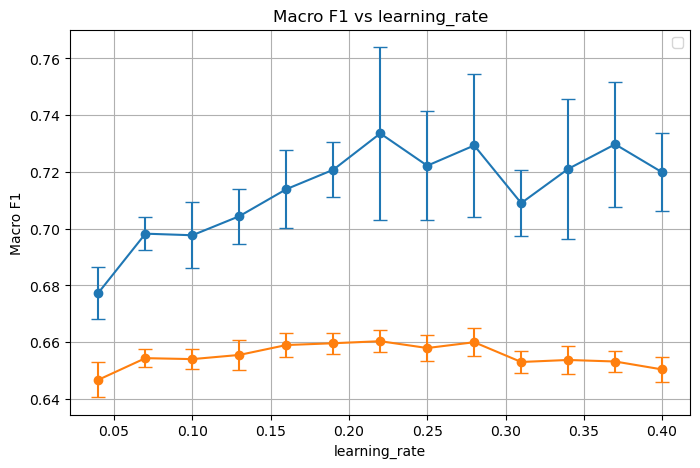

In [ ]:
print(results_df)

plt.figure(figsize=(8,5))
plt.errorbar(results_df['learning_rate'], results_df['train_mean_f1_score'], yerr=results_df['train_std_f1_score'], fmt='-o', capsize=5, label="train")
plt.errorbar(results_df['learning_rate'], results_df['val_mean_f1_score'], yerr=results_df['val_std_f1_score'], fmt='-o', capsize=5, label="val")
plt.xlabel(param_name)
plt.ylabel('Macro F1')
plt.title(f'Macro F1 vs {param_name}')
plt.grid(True)
plt.legend()
plt.show()

best param: 0.1

## Finetuning Max_depth

In [98]:
param_name = "max_depth"
param_values = np.arange(6,30,3)

print(f"Param list: {param_values}")
fixed_params = {
    # "class_weight": "balanced",
    "early_stopping": True,
    # "n_iter_no_change": 20,
    "random_state": 42,
    "tol":tolerance,
    "max_iter":3000,
    "scoring":default_scoring,
    "learning_rate": 0.1
}

# X_train_proc = preprocess.fit_transform(X_train)
output_csv_path="output/HGBC_MaxDepth_tune_1.csv"
os.makedirs(os.path.dirname(output_csv_path), exist_ok=True)

md_best_params, best_score, md_tune_results_df = tune_hgbc_param(X_train, y_train, param_name, param_values, fixed_params,output_csv_path)

Param list: [ 6  9 12 15 18 21 24 27]
max_depth = 6
max_depth = 9
max_depth = 12
max_depth = 15
max_depth = 18
max_depth = 21
max_depth = 24
max_depth = 27

Best max_depth = 12
Best CV score: 0.6553554212610164

All parameters:
{'early_stopping': True,
 'learning_rate': 0.1,
 'max_depth': np.int64(12),
 'max_iter': 3000,
 'random_state': 42,
 'scoring': 'f1_macro',
 'tol': 1e-05}
max_depth Tuning time: 424.25 seconds


   max_depth  train_mean_f1_score  train_std_f1_score  val_mean_f1_score  \
0          6             0.695899            0.012949           0.653491   
1          9             0.697955            0.015863           0.653226   
2         12             0.702951            0.010987           0.655355   
3         15             0.692694            0.023130           0.651989   
4         18             0.699024            0.013506           0.654814   
5         21             0.697667            0.011688           0.654011   
6         24             0.697667            0.011688           0.654011   
7         27             0.697667            0.011688           0.654011   

   val_std_f1_score  mean_n_iteration  std_n_iteration  
0          0.004376             228.8        50.217129  
1          0.006323             218.4        58.074435  
2          0.005957             226.6        39.887843  
3          0.011191             195.8        74.748645  
4          0.003320           

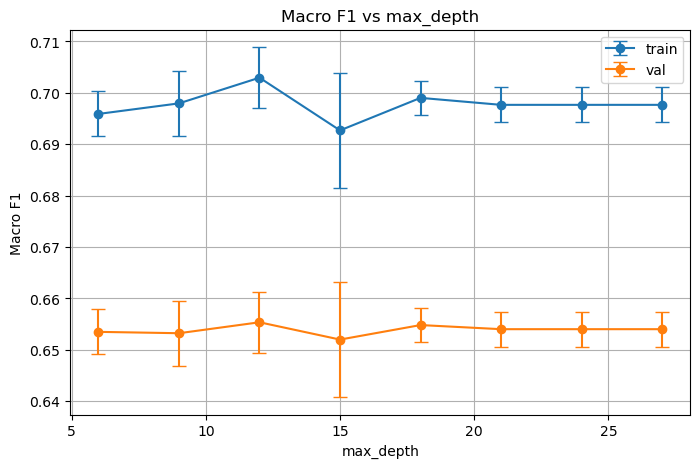

In [99]:
print(md_tune_results_df)
plt.figure(figsize=(8,5))
plt.errorbar(md_tune_results_df['max_depth'], md_tune_results_df['train_mean_f1_score'], yerr=md_tune_results_df['val_std_f1_score'], fmt='-o', capsize=5, label="train")
plt.errorbar(md_tune_results_df['max_depth'], md_tune_results_df['val_mean_f1_score'], yerr=md_tune_results_df['val_std_f1_score'], fmt='-o', capsize=5, label="val")
plt.xlabel(param_name)
plt.ylabel('Macro F1')
plt.title(f'Macro F1 vs {param_name}')
plt.grid(True)
plt.legend()
plt.show()

max_depth=6


### Tuning remaining parameters

In [ ]:
import optuna
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold

def objective(trial):
    # suggest parameters
    params = {
        "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 15, 255),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 10, 200),
        "l2_regularization": trial.suggest_float("l2_regularization", 0.0, 1.0),
        "max_features":trial.suggest_float("max_features",0.5,1.0),
        "max_bins": trial.suggest_categorical("max_bins", [60, 90, 120, 150,180,210,230,255]),
        "early_stopping": True,
        # "n_iter_no_change": 20,
        "random_state": 42,
        # "class_weight": "balanced",
        "tol": tolerance,
        "max_iter": 3000,
        "scoring": default_scoring,
        "learning_rate":0.1,
        "max_depth":18,
    }

    kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    fold_f1_scores = []
    fold_n_iteration = []
    for train_idx, val_idx in kf.split(X_train, y_train):

        X_train_sub = select_rows(X_train, train_idx)
        X_val_sub   = select_rows(X_train, val_idx)
        y_train_f   = select_rows(y_train, train_idx)
        y_val_f     = select_rows(y_train, val_idx)

        X_train_f = preprocess.fit_transform(X_train_sub)
        X_val_f   = preprocess.transform(X_val_sub)

        model = HistGradientBoostingClassifier(**params)

        model.fit(X_train_f, y_train_f, X_val=X_val_f, y_val=y_val_f)
        # print(f"Fitting stopped after {model.n_iter_} iterations")

        y_pred = model.predict(X_val_f)
        f1 = f1_score(y_val_f, y_pred, average="macro")

        fold_f1_scores.append(f1)
        fold_n_iteration.append(model.n_iter_)

    trial.set_user_attr("n_iter_mean", np.mean(fold_n_iteration))
    trial.set_user_attr("n_iter_std", np.std(fold_n_iteration))

    # Optuna optimizes *max* objective
    return np.mean(fold_f1_scores)

start_time=time.perf_counter()
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=15, n_jobs=6)
end_time=time.perf_counter()

print(f"Tuning time using Optuna: {(end_time-start_time)/60} min")

print("Best params:", study.best_params)
print("Best score:", study.best_value)

print("Mean max_iteration used in best trial:", int(study.best_trial.user_attrs["n_iter_mean"]))
print("Std max_iteration used in best trial:", int(study.best_trial.user_attrs["n_iter_std"]))

[I 2025-11-15 20:22:52,707] A new study created in memory with name: no-name-c7573fc1-1b2b-481e-b974-cad142f43f97
[I 2025-11-15 20:25:08,978] Trial 0 finished with value: 0.6627281779051172 and parameters: {'max_leaf_nodes': 79, 'min_samples_leaf': 119, 'l2_regularization': 0.2147432923678113, 'max_features': 0.9173050545616863, 'max_bins': 210}. Best is trial 0 with value: 0.6627281779051172.
[I 2025-11-15 20:26:39,609] Trial 1 finished with value: 0.663649904479259 and parameters: {'max_leaf_nodes': 208, 'min_samples_leaf': 51, 'l2_regularization': 0.5615321485364013, 'max_features': 0.5839284892522161, 'max_bins': 180}. Best is trial 1 with value: 0.663649904479259.
[I 2025-11-15 20:26:42,885] Trial 2 finished with value: 0.6613315113463619 and parameters: {'max_leaf_nodes': 191, 'min_samples_leaf': 191, 'l2_regularization': 0.6654353334139981, 'max_features': 0.5398415115596938, 'max_bins': 120}. Best is trial 1 with value: 0.663649904479259.
[I 2025-11-15 20:26:53,052] Trial 3 fin

Tuning time using Optuna: 8.757905365284143 min
Best params: {'max_leaf_nodes': 202, 'min_samples_leaf': 166, 'l2_regularization': 0.05719663222308513, 'max_features': 0.9127844482546823, 'max_bins': 255}
Best score: 0.6664300222631686
Mean max_iteration used in best trial: 92
Std max_iteration used in best trial: 7


### Tuning max_iter ( on hold )

max_iter_list: [ 50 100 150 200 250 300 350 400 450 500 550]
m_iter=50
[CV] END ..................., score=(train=0.664, test=0.637) total time=   2.5s
[CV] END ..................., score=(train=0.661, test=0.638) total time=   2.3s
[CV] END ..................., score=(train=0.667, test=0.637) total time=   2.2s
m_iter=100


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.6s finished


[CV] END ..................., score=(train=0.698, test=0.649) total time=   3.3s
[CV] END ..................., score=(train=0.695, test=0.651) total time=   3.3s
[CV] END ..................., score=(train=0.701, test=0.650) total time=   3.5s
m_iter=150


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.5s finished


[CV] END ..................., score=(train=0.725, test=0.656) total time=   4.6s
[CV] END ..................., score=(train=0.720, test=0.656) total time=   4.4s
[CV] END ..................., score=(train=0.726, test=0.655) total time=   4.6s
m_iter=200


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   16.8s finished


[CV] END ..................., score=(train=0.746, test=0.660) total time=   5.5s
[CV] END ..................., score=(train=0.742, test=0.661) total time=   5.4s
[CV] END ..................., score=(train=0.747, test=0.659) total time=   5.6s
m_iter=250


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   20.7s finished


[CV] END ..................., score=(train=0.764, test=0.661) total time=   6.8s
[CV] END ..................., score=(train=0.760, test=0.664) total time=   6.8s
[CV] END ..................., score=(train=0.764, test=0.661) total time=   6.6s
m_iter=300


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   25.4s finished


[CV] END ..................., score=(train=0.778, test=0.662) total time=   7.6s
[CV] END ..................., score=(train=0.776, test=0.666) total time=   8.0s
[CV] END ..................., score=(train=0.779, test=0.662) total time=   7.7s
m_iter=350


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   29.1s finished


[CV] END ..................., score=(train=0.791, test=0.664) total time=   8.7s
[CV] END ..................., score=(train=0.790, test=0.670) total time=   8.9s
[CV] END ..................., score=(train=0.791, test=0.661) total time=   8.8s
m_iter=400


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   33.4s finished


[CV] END ..................., score=(train=0.803, test=0.665) total time=   9.9s
[CV] END ..................., score=(train=0.803, test=0.669) total time=  10.0s
[CV] END ..................., score=(train=0.803, test=0.662) total time=   9.9s
m_iter=450


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   37.1s finished


[CV] END ..................., score=(train=0.814, test=0.663) total time=  11.0s
[CV] END ..................., score=(train=0.812, test=0.670) total time=  11.2s
[CV] END ..................., score=(train=0.813, test=0.664) total time=  11.0s
m_iter=500


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   41.6s finished


[CV] END ..................., score=(train=0.823, test=0.664) total time=  12.1s
[CV] END ..................., score=(train=0.823, test=0.669) total time=  12.8s
[CV] END ..................., score=(train=0.824, test=0.663) total time=  12.1s
m_iter=550


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   46.1s finished


[CV] END ..................., score=(train=0.833, test=0.664) total time=  13.3s
[CV] END ..................., score=(train=0.832, test=0.670) total time=  13.4s
[CV] END ..................., score=(train=0.832, test=0.663) total time=  13.4s
Max Iterationtuning time: 5.359733349998715 min
    max_iter  mean_train_f1  std_train_f1  mean_val_f1  std_val_f1
0         50       0.663694      0.002422     0.637368    0.000712
1        100       0.698059      0.002481     0.649865    0.000808
2        150       0.723802      0.002380     0.655487    0.000591
3        200       0.744886      0.002147     0.660124    0.000940
4        250       0.762698      0.001613     0.661982    0.001447
5        300       0.777616      0.000869     0.663484    0.001918
6        350       0.790771      0.000572     0.664873    0.003502
7        400       0.802909      0.000259     0.665175    0.003109
8        450       0.813239      0.000655     0.665778    0.003147
9        500       0.823286      0.0003

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   50.2s finished


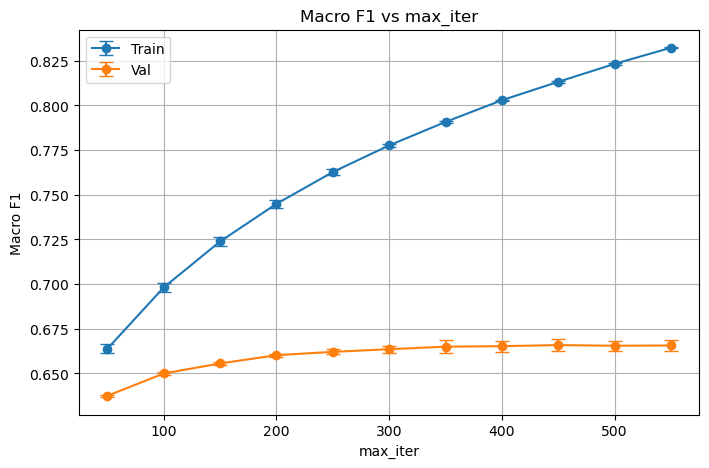

In [90]:
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import make_scorer, f1_score
import numpy as np
import pandas as pd
start_time=time.perf_counter()
max_iter_list= np.arange(50, 600, 50)
print(f"max_iter_list: {max_iter_list}")
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
f1_scorer = make_scorer(f1_score, average="macro")

results = []

for m_iter in max_iter_list:
    print(f"m_iter={m_iter}")
    params = {
        "early_stopping": False,
        "random_state": 42,
        "tol": tolerance,
        "learning_rate": 0.19,
        "max_depth": 21,
        "max_iter":m_iter,
        "scoring": default_scoring,
    }
    # params = fixed_params.copy()
    # params[param_name] = val

    model = Pipeline([
    ('preprocess', preprocess),
    ('hgbc', HistGradientBoostingClassifier(**params))
    ])

    cv_results = cross_validate(
        model,
        X_train,
        y_train,
        cv=cv,
        scoring=f1_scorer,
        return_train_score=True,
        verbose=3
    )

    mean_train_f1 = np.mean(cv_results['train_score'])
    std_train_f1 = np.std(cv_results['train_score'])
    mean_val_f1 = np.mean(cv_results['test_score'])
    std_val_f1 = np.std(cv_results['test_score'])

    results.append((m_iter, mean_train_f1, std_train_f1, mean_val_f1, std_val_f1))
end_time=time.perf_counter()
print(f"Max Iterationtuning time: {(end_time-start_time)/60} min")

# Save results
results_df = pd.DataFrame(results, columns=["max_iter", 
                                            "mean_train_f1", "std_train_f1", 
                                            "mean_val_f1", "std_val_f1"])
results_df.to_csv("output/HGBC_MaxIter_tune_1.csv", index=False)

print(results_df)
plt.figure(figsize=(8,5))
plt.errorbar(results_df['max_iter'], results_df['mean_train_f1'], yerr=results_df['std_train_f1'], fmt='-o', capsize=5, label="Train")
plt.errorbar(results_df['max_iter'], results_df['mean_val_f1'], yerr=results_df['std_val_f1'], fmt='-o', capsize=5, label="Val")
plt.xlabel("max_iter")
plt.ylabel('Macro F1')
plt.title(f'Macro F1 vs {"max_iter"}')
plt.grid(True)
plt.legend()
plt.show()

### Final parameters summary

**Tuned Parameters**
| S.N |Parametsers | Default| Tuned  |
|-----|------------|--------|--------|
| 1   | learning_rate | 0.1|-------|
| 2   | max_depth |none|-------|
| 3   | max_leaf_nodes   |31|-------|
| 4   | min_samples_leaf   |20|-------|
| 5   | max_features   |1.0|-------|
| 6   | l2_regularization   |0|-------|


## Tuned Model

Best params: {'max_leaf_nodes': 202, 'min_samples_leaf': 166, 'l2_regularization': 0.05719663222308513, 'max_features': 0.9127844482546823, 'max_bins': 255}

Best score: 0.6664300222631686

Mean max_iteration used in best trial: 92

Std max_iteration used in best trial: 7

Model Training time: 12.67 seconds

===Result of Model Training with Default Params====
Fitting stopped after 100 iterations

---Accuracy---
Train Accuracy: 78.30
Test Accuracy: 72.99

---Macro F1-score---
Train Macro F1-score: 74.94
Test Macro F1-score: 67.14


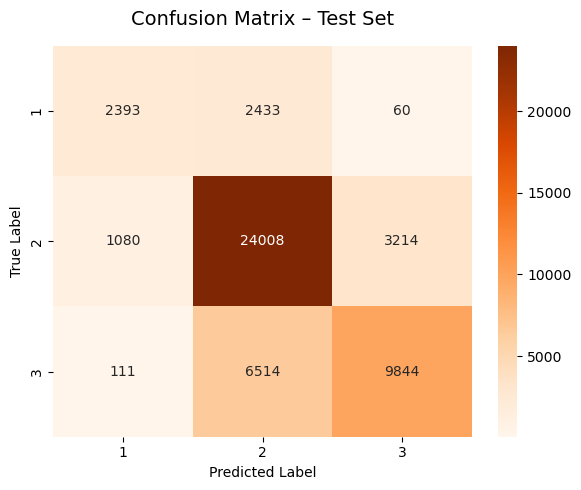

<Figure size 640x480 with 0 Axes>


---Default Hyperparameters of HistGradientBoostingClassifier---
{'categorical_features': 'from_dtype',
 'class_weight': None,
 'early_stopping': False,
 'interaction_cst': None,
 'l2_regularization': 0.05,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_bins': 255,
 'max_depth': 18,
 'max_features': 0.91,
 'max_iter': 100,
 'max_leaf_nodes': 202,
 'min_samples_leaf': 166,
 'monotonic_cst': None,
 'n_iter_no_change': 10,
 'random_state': 42,
 'scoring': 'f1_macro',
 'tol': 1e-05,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

hgbc_model = Pipeline([
    ('preprocess', preprocess),
    ('hgbc', HistGradientBoostingClassifier(
        learning_rate=0.1,
        max_depth=18,
        max_leaf_nodes= 202,
        min_samples_leaf= 166,
        l2_regularization=0.05,
        max_features=0.91,
        max_bins=255,
        random_state= 42,
        # class_weight= "balanced",
        tol= tolerance,
        max_iter= 100,
        scoring= default_scoring,
        # validation_fraction=0.2,
        early_stopping= False,
        # n_iter_no_change= 30,
        ))
])
start_time=time.perf_counter()
hgbc_model.fit(X_train, y_train)
end_time=time.perf_counter()
elapsed_time=end_time-start_time
print(f"Model Training time: {elapsed_time:.2f} seconds")

y_train_pred_default = hgbc_model.predict(X_train)
y_test_pred_default = hgbc_model.predict(X_test)

train_accuracy_1 = accuracy_score(y_train, y_train_pred_default)
train_macro_f1_1 = f1_score(y_train, y_train_pred_default, average='macro')
test_accuracy_1 = accuracy_score(y_test, y_test_pred_default)
test_macro_f1_1 = f1_score(y_test, y_test_pred_default, average='macro')

print("\n===Result of Model Training with Default Params====")
print(f"Fitting stopped after {hgbc_model.named_steps['hgbc'].n_iter_} iterations")
print("\n---Accuracy---")
print(f"Train Accuracy: {train_accuracy_1*100:.2f}")
print(f"Test Accuracy: {test_accuracy_1*100:.2f}")
print("\n---Macro F1-score---")
print(f"Train Macro F1-score: {train_macro_f1_1*100:.2f}")
print(f"Test Macro F1-score: {test_macro_f1_1*100:.2f}")
# Compute confusion matrix for the test set
cm_test = confusion_matrix(y_test, y_test_pred_default)

# Unique class labels (handles 2-class or multi-class)
labels = np.unique(np.concatenate([y_test, y_test_pred_default]))

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_test,
    annot=True,                # show counts
    fmt='d',                   # integer format
    cmap='Oranges',
    xticklabels=labels,
    yticklabels=labels,
    cbar=True
)

plt.title('Confusion Matrix – Test Set', fontsize=14, pad=15)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

# All hyperparameters (what was passed to the model)
print("\n---Default Hyperparameters of HistGradientBoostingClassifier---")
pprint( hgbc_model.named_steps['hgbc'].get_params())

In [95]:
import pandas as pd
import numpy as np

# Feature importance array
importances = hgbc_model.named_steps['hgbc']

# If you have a DataFrame for X_train
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'feature_{i}' for i in range(X_train.shape[1])]

# Create a DataFrame for easy plotting
feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(feat_imp_df)


TypeError: '<' not supported between instances of 'HistGradientBoostingClassifier' and 'HistGradientBoostingClassifier'

# Models Comparison


**Metric Comparision**

| S.N | Metric      |DummyClassifier (Baseline) | Random Forest                   | HistGradientBoostingClassifier  |
|-----|-------------|---|---|---|
| 1   | Accuracy    | --|---|--|
| 2   | Macro Recall    | --|---|---|
| 3   | Macro Precision    | --|----|----|
| 4   | Macro F1    | --|----|---|



**Feature Importance Comparision**

| S.N |Random Forest| HistGradientBoostingClassifier  |
|-----|-------------|---|
| 1   |     | --|
| 2   |    | --|
| 3   |    | --|
| 4   |    | --|
| 4   |    | --|
